# Importing libraries & modules 

In [669]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox

pd.options.display.max_rows = 50

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## EDA & Data Cleaning

### loading & exploring the data

In [670]:
re_df = pd.read_excel('Data_MidTerm_Project_Real_State_Regression.xls')

In [671]:
re_df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [672]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

### Dropping columns

In [673]:
re_df.drop(['id'],axis=1, inplace=True)
re_df.drop(['date'],axis=1, inplace=True)
re_df.drop(['sqft_above'],axis=1, inplace=True)
re_df.drop(['sqft_lot'],axis=1, inplace=True)
re_df.drop(['yr_renovated'],axis=1, inplace=True)

### creating a new column area

1. group zipcodes and show average price
2. sort groups by average price
3. set threshold values
4. create new column "area" with 5 zipcode groups

In [674]:
grouped_zipcodes = re_df.groupby("zipcode")[["price"]].mean().sort_values(by="price", ascending=False)

very_affordable_area =list(grouped_zipcodes[grouped_zipcodes["price"]< 250000].index)
affordable_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 250000) & (grouped_zipcodes["price"] < 500000)].index)
medium_priced_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 500000) & (grouped_zipcodes["price"]< 750000)].index)
expensive_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 750000) & (grouped_zipcodes["price"]< 1000000)].index)
very_expensive_area =list(grouped_zipcodes[grouped_zipcodes["price"]>=1000000].index)

area = []

for row in re_df['zipcode']:
    if row in very_affordable_area:
        area.append('very_affordable area')
    elif row in affordable_area:
        area.append('affordable area')
    elif row in medium_priced_area:
        area.append('medium priced area')
    elif row in expensive_area:
        area.append('expensive area')
    elif row in very_expensive_area:
        area.append('very expensive area')

re_df['area'] = area 

Delete "zipcode" column, as it probably correlates too strongly with the new "area" column

In [675]:
re_df.drop(['zipcode'],axis=1, inplace=True)

### removing duplicates

In [676]:
re_df.drop_duplicates(inplace=True)

### renaming waterfront column features

Only for better readability, will later be encoded as dummy again

In [677]:
def clean_waterfront(x):
    if x == 0:
        return 'no'
    elif x == 1:
        return 'yes'

In [678]:
re_df["waterfront"] = list(map(clean_waterfront,re_df["waterfront"])) 

### removing outliers

#### bedrooms

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms'>

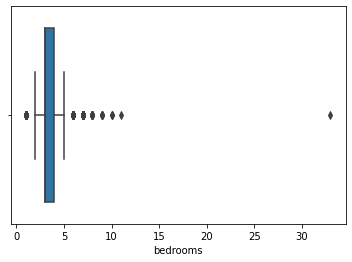

In [679]:
sns.boxplot(re_df['bedrooms'])

In [680]:
max(re_df['bedrooms'])

33

33 bedrooms seems to be a mistake, the correct amount of bedrooms should be 3, according to the other features of the house

In [681]:
re_df.loc[re_df['bedrooms'] == 33]

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,price,area
18069,33,1.75,1620,1.0,no,0,5,7,580,1947,47.6878,-122.331,1330,4700,640000,medium priced area


Change 33 bedrooms  to 3

In [682]:
re_df.at[15856,'bedrooms'] = 3

#### price

All houses above $4 Mio. seem to be outliers

In [683]:
re_df = re_df[re_df['price'] < 4000000]

## Export to Tableau 

In [684]:
re_df.to_excel(r'cleaned_dataframe.xlsx', index = False)

## Plotting the Correlation Heatmap

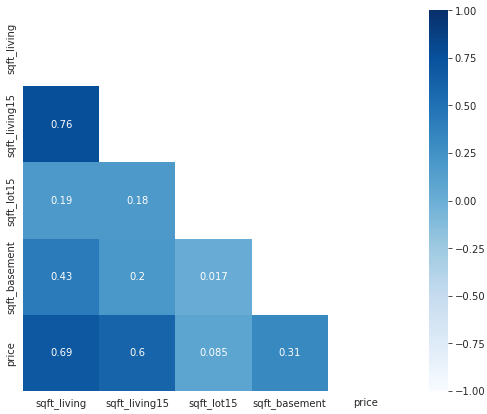

In [685]:
re_num = re_df[['sqft_living','sqft_living15','sqft_lot15','sqft_basement','price']]

corr = re_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap="Blues", vmin=-1,vmax=1,annot=True, square=True)

## X/Y split

Split target variable y = "price" from the rest of the dataset

In [686]:
X=re_df.drop("price", axis=1)
y=re_df["price"]

## Data Splitting

In [687]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [688]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Data Transformation

### Hot coding Categorical Variables

In [689]:
X_train_cat=X_train[['bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','lat','long','area']]
X_train_cat

X_test_cat=X_test[['bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','lat','long','area']]
X_test_cat

,bedrooms,bathrooms,view,floors,waterfront,condition,grade,yr_built,lat,long,area
12573,6,3.00,0,2.0,no,3,7,2006,47.2773,-122.216,very_affordable area
18847,3,1.50,0,1.0,no,4,6,1949,47.4878,-122.314,very_affordable area
6909,3,1.00,0,1.0,no,3,5,1943,47.4940,-122.275,affordable area
18875,2,1.50,0,1.5,no,3,6,1970,47.6487,-122.122,medium priced area
7251,3,1.00,0,1.0,no,2,7,1943,47.3514,-122.315,affordable area
...,...,...,...,...,...,...,...,...,...,...,...
11149,4,1.75,0,1.0,no,5,7,1960,47.6060,-122.135,medium priced area
5860,3,3.00,0,1.5,no,3,7,1949,47.7183,-122.285,affordable area
7132,4,1.00,0,1.0,no,3,7,1973,47.7204,-122.180,medium priced area
19082,2,2.25,0,2.0,no,3,7,2009,47.5321,-122.073,medium priced area


In [690]:
X_train_cat=pd.get_dummies(X_train_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_train_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_train_cat).get_feature_names(input_features=X_train_cat.columns))

X_test_cat=pd.get_dummies(X_test_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_test_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_test_cat).get_feature_names(input_features=X_test_cat.columns))

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_11,bathrooms_0.75,...,long_-121.698,long_-121.691,long_-121.676,long_-121.417,long_-121.319,waterfront_yes_1,area_expensive area_1,area_medium priced area_1,area_very expensive area_1,area_very_affordable area_1
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6470,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6471,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [691]:
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat = X_test_cat.reset_index(drop=True)

### Standardize numerical values

In [692]:
X_train_num=X_train[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_train_num

X_test_num=X_test[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_test_num

,sqft_living,sqft_living15,sqft_lot15,sqft_basement
12573,2744,2470,9926,0
18847,1230,850,6714,0
6909,840,1010,6000,0
18875,1310,2970,12196,0
7251,1240,1240,18000,0
...,...,...,...,...
11149,1820,1430,8800,0
5860,2150,1730,4609,610
7132,1980,1570,7626,720
19082,1170,1240,750,0


In [693]:
std_scaler=StandardScaler().fit(X_train_num)  
X_train_scaled=std_scaler.transform(X_train_num)

In [694]:
X_test_scaled=std_scaler.transform(X_test_num)

In [695]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

[[ 0.41845838 -0.14294809 -0.33399668  1.20523432]
 [-0.68275959 -0.28843688 -0.3194736  -0.65653123]
 [-0.92502754 -0.44847455 -0.33399668 -0.65653123]
 ...
 [-0.41846728 -0.57941447 -0.16066378  0.5695095 ]
 [-0.2973333  -0.82674542 -0.02966565 -0.65653123]
 [-0.06607753 -0.21569248 -0.3194736   1.63661902]]
--------
[[ 0.73120428  0.70088692 -0.10431425 -0.65653123]
 [-0.93603972 -1.65603154 -0.22093454 -0.65653123]
 [-1.36551473 -1.42324947 -0.24685823 -0.65653123]
 ...
 [-0.11012624 -0.60851223 -0.18782193  0.97818974]
 [-1.0021128  -1.08862525 -0.43747358 -0.65653123]
 [ 1.2223475   1.23919546 -0.3194736   1.11441649]]


In [696]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test_num.columns)

In [697]:
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)

### Quantile Transformer

In [698]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_living15'] = qt.transform(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_living15'] = qt.transform(X_test_scaled['sqft_living15'].to_numpy().reshape(-1,1))

In [699]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_lot15'] = qt.transform(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_lot15'] = qt.transform(X_test_scaled['sqft_lot15'].to_numpy().reshape(-1,1))

In [700]:
qt = QuantileTransformer(output_distribution="normal").fit(y_train.to_numpy().reshape(-1,1))
y_train = qt.transform(y_train.to_numpy().reshape(-1,1))
y_test = qt.transform(y_test.to_numpy().reshape(-1,1))

## Concatination 

In [701]:
X_train_con=pd.concat([X_train_scaled,X_train_cat],axis=1)
X_test_con=pd.concat([X_test_scaled,X_test_cat],axis=1)

In [702]:
X_train_con

,sqft_living,sqft_living15,sqft_lot15,sqft_basement,bedrooms,bathrooms,view,floors,condition,grade,yr_built,lat,long,waterfront_yes,area_expensive area,area_medium priced area,area_very expensive area,area_very_affordable area
0,0.418458,0.071571,-1.327982,1.205234,4,2.75,0,2.0,3,8,1907,47.6093,-122.297,0,0,1,0,0
1,-0.682760,-0.081638,-1.147315,-0.656531,3,1.00,0,1.0,4,7,1934,47.6837,-122.320,0,0,1,0,0
2,-0.925028,-0.271787,-1.327982,-0.656531,3,1.00,0,1.5,3,7,1902,47.5986,-122.298,0,0,1,0,0
3,0.308337,0.676854,-0.817260,-0.656531,4,2.50,0,2.0,3,8,2003,47.7731,-122.167,0,0,0,0,0
4,1.233360,1.368450,-0.275827,-0.656531,3,2.75,0,2.0,3,9,2004,47.5884,-121.991,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15097,0.528580,0.203379,0.139710,1.727437,3,2.25,0,1.0,3,8,1958,47.7124,-122.303,0,0,0,0,0
15098,-1.200332,-1.258508,-1.512406,-0.656531,2,1.00,0,2.0,3,7,1998,47.5919,-122.297,0,0,1,0,0
15099,-0.418467,-0.444534,0.244976,0.569510,3,2.50,0,1.0,3,8,1998,47.5369,-122.378,0,0,0,0,0
15100,-0.297333,-0.837338,0.936306,-0.656531,3,2.00,0,1.0,3,7,1967,47.6393,-121.967,0,0,1,0,0


##  Apply Linear Regression

### Modelling using Statsmodels

In [703]:
X_train_const_scaled = sm.add_constant(X_train_con)

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_con) 
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     3940.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:19:18   Log-Likelihood:                -8298.8
No. Observations:               15102   AIC:                         1.664e+04
Df Residuals:                   15083   BIC:                         1.678e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [704]:
predictions_test

0      -1.051661
1      -1.617309
2      -1.618504
3      -0.209933
4      -1.399489
          ...   
6468    0.087522
6469   -0.039845
6470    0.002334
6471   -0.506602
6472    1.715994
Length: 6473, dtype: float64

Display adjusted r-squared

In [705]:
print(model.rsquared_adj)

0.8243966979732811


### Modeling using Scikit Learn

In [706]:
model=LinearRegression() 
model.fit(X_train_con, y_train) 

LinearRegression()

In [707]:
model.coef_

array([[ 2.89323115e-01,  1.16956690e-01, -2.50739098e-02,
        -3.45013132e-02, -1.39788992e-03,  1.01275640e-01,
         1.09637090e-01,  5.00739382e-02,  1.06449768e-01,
         1.92545383e-01, -3.47294090e-03,  1.69918892e+00,
        -2.61104556e-01,  7.25411983e-01,  7.12216908e-01,
         4.99665274e-01,  1.11745834e+00, -3.79939493e-01]])

In [708]:
model.intercept_

array([-108.32351006])

Making a prediction

In [709]:
y_pred=model.predict(X_test_con)   

In [710]:
y_test

array([[-0.81614989],
       [-2.36524765],
       [-2.55030515],
       ...,
       [ 0.26528387],
       [-0.57385479],
       [ 1.73873105]])

In [711]:
y_pred

array([[-1.05166082],
       [-1.6173088 ],
       [-1.61850409],
       ...,
       [ 0.00233425],
       [-0.50660189],
       [ 1.71599407]])

In [712]:
y_test = y_test.reshape(len(y_test))
y_pred = y_pred.reshape(len(y_pred))

In [713]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

,y_test,y_pred
0,-0.816150,-1.051661
1,-2.365248,-1.617309
2,-2.550305,-1.618504
3,0.023839,-0.209933
4,-1.387908,-1.399489
...,...,...
6468,0.274391,0.087522
6469,-0.155180,-0.039845
6470,0.265284,0.002334
6471,-0.573855,-0.506602


1. Create scatterplot y_pre vs y to check whether predictions make sense (should be a straight line)
2. Create histogram of the residuals:  y - y_pred to check for homoscedasticity (-> variance of the dependent variable is the same for all the data) (should be a normal distribution)
3. Show residuals by predicted values (the closer the values are to the horizontal line, the more acurate the model)

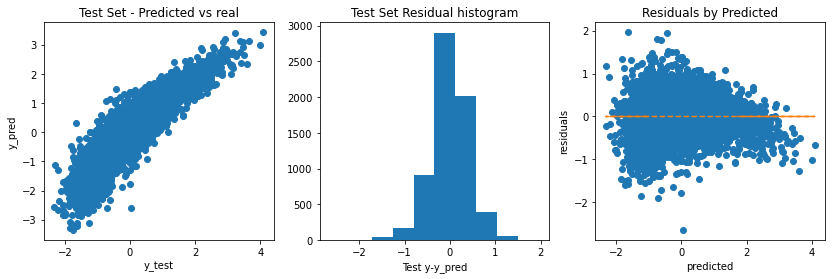

In [714]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs real")

ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

#### Error metrics

In [715]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

0.16914015410783395
0.31152396393344284


In [716]:
R2=r2_score(y_test,y_pred)
R2

0.8289600389384125

In [717]:
X_test.shape[1]

15

In [718]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.8285627028046161

#### Feature Importance

In [719]:
coef = model.coef_.reshape(model.coef_.shape[1])

In [720]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_con.columns,
    'Importance': abs(coef)
})
features_importances = features_importances.sort_values(by='Importance')

In [721]:
features_importances

,Attribute,Importance
4,bedrooms,0.001398
10,yr_built,0.003473
2,sqft_lot15,0.025074
3,sqft_basement,0.034501
7,floors,0.050074
5,bathrooms,0.101276
8,condition,0.106450
6,view,0.109637
1,sqft_living15,0.116957
9,grade,0.192545


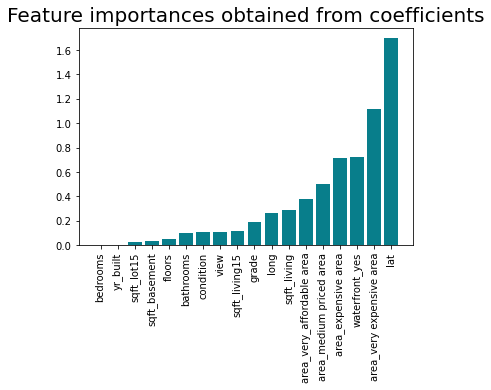

In [722]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Evaluating predictions

MAE: mean absolute error

In [723]:
MAE = np.mean( np.abs( y_test - y_pred ) )
MAE

0.31152396393344284

MSE: mean squared error

In [724]:
MSE = np.mean( np.power( y_test - y_pred , 2 ) )
MSE

0.16914015410783395

RMSE: root mean squared error

In [725]:
RMSE = np.sqrt(MSE)
RMSE

0.4112665244191824

Histogram of entire df

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

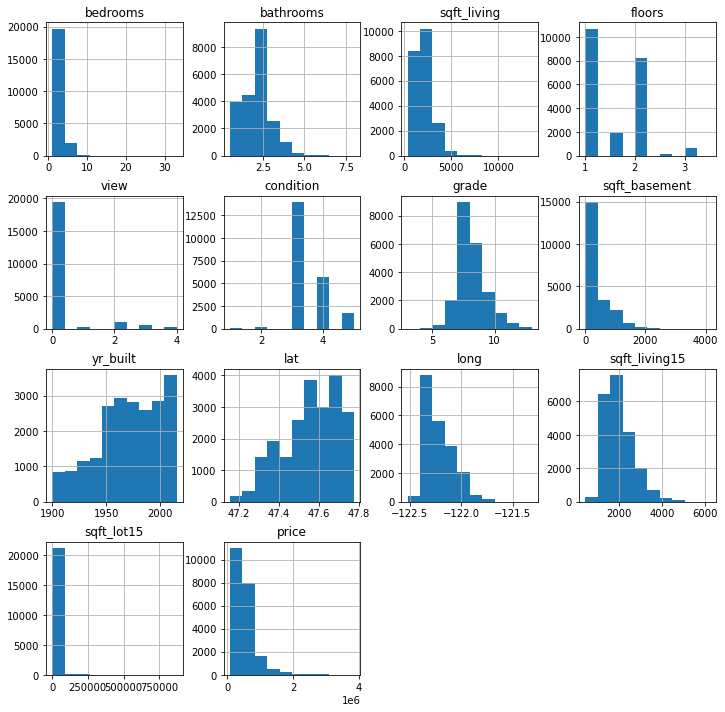

In [726]:
re_df.hist(figsize=(12,12))